### Data Transformation

### Text Splitting with Langchain
This script demonstrates:
1) RecursiveCharacterTextSplitter on PDF and TXT
2) CharacterTextSplitter (two variants: from Documents vs from raw string)
3) RecursiveJsonSplitter for hierarchical JSON

Assumed project layout (from inside the notebook in 'RAG Pipeline'):
  ../data/AI_and_society.txt
  ../data/Attention is all you need.pdf

In [1]:
from pathlib import Path
from typing import List

# --- Loader & Splitter imports ---
from langchain_community.document_loaders import TextLoader, PyPDFLoader
from langchain_text_splitters import (
    RecursiveCharacterTextSplitter,
    CharacterTextSplitter,
    RecursiveJsonSplitter,
)


def preview_docs(docs: List, n: int = 2) -> None:
    """Print a brief preview of the first `n` documents (content + metadata)."""
    if not docs:
        print("No documents.")
        return
    for i, d in enumerate(docs[:n], 1):
        content = getattr(d, "page_content", "")
        meta = getattr(d, "metadata", {})
        print(f"\n--- Document {i} ---")
        print(content[:300] + ("..." if len(content) > 300 else ""))
        print("Metadata:", meta)

c:\Users\gauricchio\AppData\Local\miniconda3\envs\genai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1) Recursive Character Text Splitter
Goal:
 - Split text into chunks with a max size (**chunk_size**) and an overlap (**chunk_overlap**)
 - Overlap preserves context across adjacent chunks

Parameters:
- *chunk_size*=500
Defines the maximum size of each text piece (chunk) in terms of number of characters.
Each resulting segment will therefore contain at most 500 characters.

- *chunk_overlap*=50
Specifies the number of characters that overlap between two consecutive chunks.
This overlap helps preserve context from one piece to the next, which is useful for NLP models that analyze text sequences.
Thanks to the overlap, each chunk retains part of the context from the previous one, improving the quality of analysis in language models.

##### 1a) On a PDF


In [2]:
try:
    pdf_path = Path("../data/Attention is all you need.pdf")
    if not pdf_path.exists():
        raise FileNotFoundError(f"PDF not found: {pdf_path.resolve()}")

    pdf_docs = PyPDFLoader(str(pdf_path)).load()

    #chunk_size=500 chars, chunk_overlap=50 chars
    rsplit_pdf = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    pdf_chunks = rsplit_pdf.split_documents(pdf_docs)

    print(f"PDF split into {len(pdf_chunks)} chunks.")
    preview_docs(pdf_chunks)
except Exception as e:
    print("PDF splitting error:", e)

PDF split into 93 chunks.

--- Document 1 ---
Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.
Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com
Niki Par...
Metadata: {'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2024-04-10T21:11:43+00:00', 'author': '', 'keywords': '', 'moddate': '2024-04-10T21:11:43+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': '..\\data\\Attention is all you need.pdf', 'total_pages': 15, 'page': 0, 'page_label': '1'}

--- Document 2 ---
University of Toronto
aidan@cs.toronto.edu
Łukasz Kaiser∗
Google Brain
lukaszkaiser@google.com
Illia Polosukhin∗ ‡
illia.polosukhin@gmail.com
Abstract
The dominant sequence transdu

##### 1b) On a txt file


In [4]:
try:
    txt_path = Path("../data/AI_and_society.txt")
    if not txt_path.exists():
        raise FileNotFoundError(f"Text file not found: {txt_path.resolve()}")

    txt_docs = TextLoader(str(txt_path)).load()

    #Use smaller chunks to make overlap visible in prints
    rsplit_txt = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=40)
    txt_chunks = rsplit_txt.split_documents(txt_docs)

    print(f"\n TXT split into {len(txt_chunks)} chunks (with overlap).")
    #Show first two chunks to illustrate the overlapping segment
    preview_docs(txt_chunks, n=3)
except Exception as e:
    print("TXT splitting error:", e)


 TXT split into 30 chunks (with overlap).

--- Document 1 ---
Artificial Intelligence and Society
Metadata: {'source': '..\\data\\AI_and_society.txt'}

--- Document 2 ---
Artificial Intelligence (AI) is rapidly transforming the way we live, work, and interact with
Metadata: {'source': '..\\data\\AI_and_society.txt'}

--- Document 3 ---
way we live, work, and interact with technology.
Metadata: {'source': '..\\data\\AI_and_society.txt'}


#### 2) Recursive Character Text Splitter
CharacterTextSplitter splits by a given separator; if the separator isn’t found, chunks can be larger than expected (it tries not to break mid-block)

##### 2a) Variant 1: 
- In this case the text is loaded using *TextLoader* from LangChain;
- *load()* returns a list of documents (docs) where each doc is represented loke a *Document* object with some attributes as "*page content*" and "*metadata*";
- After applying "*CharacterTextSplitter*", "*split_documents (docs)*" method takes the documents loaded with TextLoader and divide them into chunks.

In [8]:
try:
    docs_v1 = TextLoader(str(txt_path)).load()  #Document objects
    csplit_v1 = CharacterTextSplitter(
        separator="\n\n",  #try to split at paragraph boundaries
        chunk_size=100,
        chunk_overlap=20,
    )
    chunks_v1 = csplit_v1.split_documents(docs_v1)
    print(f"\n CharacterTextSplitter (Variant 1) produced {len(chunks_v1)} chunks.")
    preview_docs(chunks_v1, n=2)

    #if the separator "\n\n" is rare, some chunks may exceed 100 chars:
    #the splitter prefers not to break inside a “paragraph block”.
except Exception as e:
    print("CharacterTextSplitter Variant 1 error:", e)


Created a chunk of size 355, which is longer than the specified 100
Created a chunk of size 441, which is longer than the specified 100
Created a chunk of size 422, which is longer than the specified 100
Created a chunk of size 303, which is longer than the specified 100



 CharacterTextSplitter (Variant 1) produced 6 chunks.

--- Document 1 ---
Artificial Intelligence and Society
Metadata: {'source': '..\\data\\AI_and_society.txt'}

--- Document 2 ---
Artificial Intelligence (AI) is rapidly transforming the way we live, work, and interact with technology. 
Today, AI systems are able to recognize speech, translate languages, diagnose diseases, and even create art. 
These capabilities open new possibilities for innovation across industries, includi...
Metadata: {'source': '..\\data\\AI_and_society.txt'}


--> It created bigger chuncks then those we specified (len=100). That's beacause it wasn't able to fund the separator we indicated.

##### 2b) Variant 2: 
- In this case the file is opended with *open()* method and completely read with *read()* and saved as string in the speech variable;
- Despite of *Variant 1*, the text is managed like a simple string, while before it was loaded like a *Document* object;
- In this case *create_documents* works on a string and not on already formatted documents.

In [9]:
try:
    #read raw text yourself (no Document object yet)
    speech_text = Path(txt_path).read_text(encoding="utf-8")

    csplit_v2 = CharacterTextSplitter(
        #default separator is "\n\n" if not specified
        chunk_size=100,
        chunk_overlap=20,
    )
    #create_documents expects a list[str]; it will generate Documents for you
    chunks_v2 = csplit_v2.create_documents([speech_text])

    print(f"\n CharacterTextSplitter (Variant 2) produced {len(chunks_v2)} chunks.")
    preview_docs(chunks_v2, n=2)
except Exception as e:
    print("CharacterTextSplitter Variant 2 error:", e)

Created a chunk of size 355, which is longer than the specified 100
Created a chunk of size 441, which is longer than the specified 100
Created a chunk of size 422, which is longer than the specified 100
Created a chunk of size 303, which is longer than the specified 100



 CharacterTextSplitter (Variant 2) produced 6 chunks.

--- Document 1 ---
Artificial Intelligence and Society
Metadata: {}

--- Document 2 ---
Artificial Intelligence (AI) is rapidly transforming the way we live, work, and interact with technology. 
Today, AI systems are able to recognize speech, translate languages, diagnose diseases, and even create art. 
These capabilities open new possibilities for innovation across industries, includi...
Metadata: {}


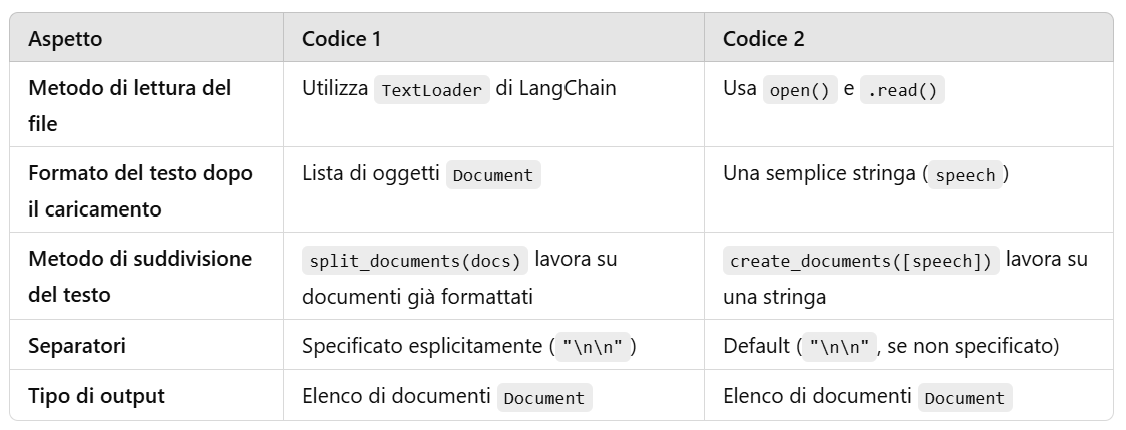

In [11]:
from IPython.display import display, Image
display(Image("C:/Users/utente/Desktop/CORSO NLP e GENERATIVE AI/Materiale Corso/Immagini/Immagine 2025-03-28 103144.png", width=700))

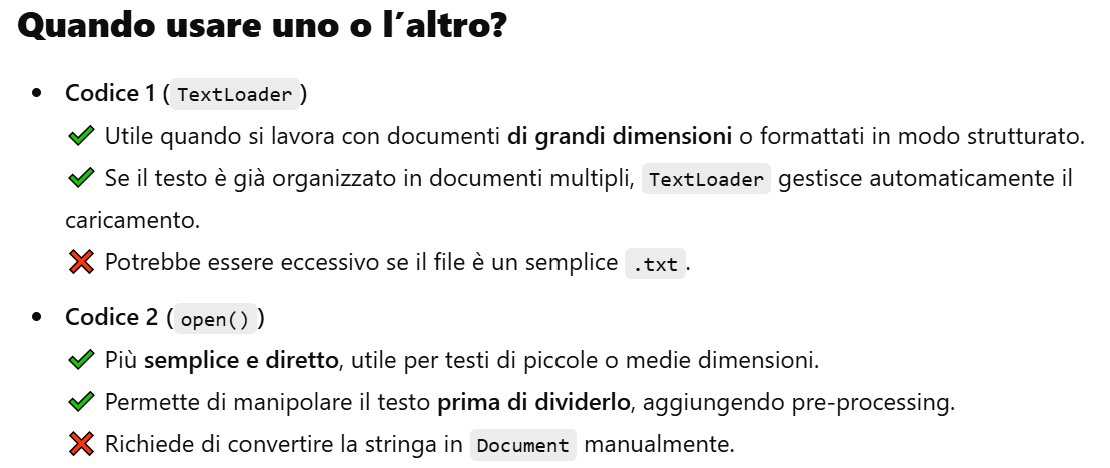

In [ ]:
from IPython.display import display, Image
display(Image("C:/Users/utente/Desktop/CORSO NLP e GENERATIVE AI/Materiale Corso/Immagini/Immagine 2025-03-28 103111.png", width=700))

#### 3) JSON Recursive Splitter
 Use RecursiveJsonSplitter to traverse nested JSON and chunk it respecting structure

In [10]:
try:
    import requests

    #example public OpenAPI JSON
    json_url = "https://api.smith.langchain.com/openapi.json"
    json_data = requests.get(json_url, timeout=30).json()

    #create splitter: max_chunk_size applies to serialized token/char length estimate
    json_splitter = RecursiveJsonSplitter(max_chunk_size=300)

    #3A) Low-level chunks as dictionaries
    json_chunks = json_splitter.split_json(json_data)
    print(f"\n JSON split into {len(json_chunks)} structural chunks.")
    for c in json_chunks[:3]:
        print("\n[JSON chunk excerpt]")
        print(str(c)[:300] + "...")

    #3B) LangChain Documents from JSON (with page_content + metadata)
    json_docs = json_splitter.create_documents(texts=[json_data])
    print(f"\n JSON converted to {len(json_docs)} Document(s).")
    preview_docs(json_docs, n=2)

    #3C) Plain text chunks (no Document wrapper)
    json_texts = json_splitter.split_text(json_data)
    print(f"\n JSON text split into {len(json_texts)} text chunks.")
    print("\n[Text chunk 1]\n", json_texts[0][:300], "...")
    print("\n[Text chunk 2]\n", json_texts[1][:300], "...")
except Exception as e:
    print("JSON splitting error:", e)


 JSON split into 3186 structural chunks.

[JSON chunk excerpt]
{'openapi': '3.1.0', 'info': {'title': 'LangSmith', 'version': '0.1.0'}, 'paths': {'/api/v1/sessions/{session_id}/dashboard': {'post': {'tags': ['tracer-sessions'], 'summary': 'Get Tracing Project Prebuilt Dashboard', 'description': 'Get a prebuilt dashboard for a tracing project.'}}}}...

[JSON chunk excerpt]
{'paths': {'/api/v1/sessions/{session_id}/dashboard': {'post': {'operationId': 'get_tracing_project_prebuilt_dashboard_api_v1_sessions__session_id__dashboard_post', 'security': [{'API Key': []}, {'Tenant ID': []}, {'Bearer Auth': []}]}}}}...

[JSON chunk excerpt]
{'paths': {'/api/v1/sessions/{session_id}/dashboard': {'post': {'parameters': [{'name': 'session_id', 'in': 'path', 'required': True, 'schema': {'type': 'string', 'format': 'uuid', 'title': 'Session Id'}}, {'name': 'accept', 'in': 'header', 'required': False, 'schema': {'anyOf': [{'type': 'string'},...

 JSON converted to 3186 Document(s).

--- Document 1 --

In [11]:
json_data

{'openapi': '3.1.0',
 'info': {'title': 'LangSmith', 'version': '0.1.0'},
 'paths': {'/api/v1/sessions/{session_id}/dashboard': {'post': {'tags': ['tracer-sessions'],
    'summary': 'Get Tracing Project Prebuilt Dashboard',
    'description': 'Get a prebuilt dashboard for a tracing project.',
    'operationId': 'get_tracing_project_prebuilt_dashboard_api_v1_sessions__session_id__dashboard_post',
    'security': [{'API Key': []}, {'Tenant ID': []}, {'Bearer Auth': []}],
    'parameters': [{'name': 'session_id',
      'in': 'path',
      'required': True,
      'schema': {'type': 'string', 'format': 'uuid', 'title': 'Session Id'}},
     {'name': 'accept',
      'in': 'header',
      'required': False,
      'schema': {'anyOf': [{'type': 'string'}, {'type': 'null'}],
       'title': 'Accept'}}],
    'requestBody': {'required': True,
     'content': {'application/json': {'schema': {'$ref': '#/components/schemas/CustomChartsSectionRequest'}}}},
    'responses': {'200': {'description': 'Succ